# Performing a Sky Simulation with RFI Sources

This example shows how to include RFI into the simulation. We take an arbitrary sky and use karabo to simulate the visibilities and the interference due to satellites.

In [1]:
import os
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope, VLAVersions
from karabo.simulation.beam import generate_gaussian_beam_data
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation
from rascil.processing_components import create_visibility_from_ms
from karabo.simulator_backend import SimulatorBackend
from karabo.util.file_handler import FileHandler
from karabo.simulation.signal.rfi_signal import RFISignal

import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime, timedelta
from pathlib import Path

from karabo.util.ska_sdp_datamodels.visibility.vis_io_ms import (  # type: ignore[attr-defined] # noqa: E501
    export_visibility_to_ms,
)
from karabo.imaging.imager_rascil import RascilDirtyImager, RascilDirtyImagerConfig
from ska_sdp_datamodels.image import create_image

import matplotlib.pyplot as plt

%matplotlib inline

/home/andreas/miniconda3/envs/karabo-dev310/lib/python3.10/site-packages/ska_sdp_datamodels/configuration/config_create.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


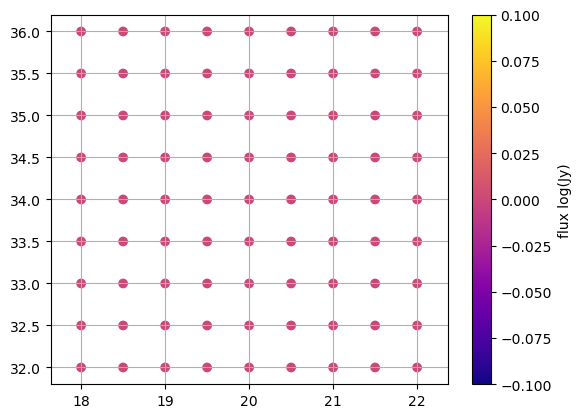

In [2]:
phasecenter = (20, 34)
# Read in and plot the sky model
# sky = SkyModel.sky_test()

sky = SkyModel()
sky_data = np.zeros((81, SkyModel.SOURCES_COLS))
a = np.arange(32, 36.5, 0.5)
b = np.arange(18, 22.5, 0.5)
dec_arr, ra_arr = np.meshgrid(a, b)
sky_data[:, 0] = ra_arr.flatten()
sky_data[:, 1] = dec_arr.flatten()
sky_data[:, 2] = 1
sky.add_point_sources(sky_data)


# Sky Model if you want ONE POINT SOURCE ONLY
# sky = SkyModel()
# sky_data = np.array([[20.0, -30.0, 1]])
# sky.add_point_sources(sky_data)

sky.explore_sky(phase_center=phasecenter, wcs_enabled=False)

In [3]:
# Parameter definition
ra_deg = phasecenter[0]
dec_deg = phasecenter[1]
start_time = datetime(2000, 3, 20, 6, 6, 39)
obs_length = timedelta(hours=0, minutes=15, seconds=0, milliseconds=0)
start_freq = 1.5e8
freq_bin = 1.0e7
number_of_time_steps = 100
number_of_channels = 2

In [4]:
# Set Imaging parameters
fov = 10 / 180 * np.pi
imaging_cellsize = (1.2 / 60) / 180 * np.pi
imaging_npixel = int(fov / imaging_cellsize)
imaging_npixel = imaging_npixel if imaging_npixel % 2 == 0 else imaging_npixel + 1
print(f"Image size of : {imaging_npixel}")

dirty_imager_config = RascilDirtyImagerConfig(
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
)
dirty_imager = RascilDirtyImager(dirty_imager_config)

Image size of : 500


In [5]:
# Simulation settings that are the same for OSKAR and RASCIL
observation = Observation(
    phase_centre_ra_deg=ra_deg,
    phase_centre_dec_deg=dec_deg,
    start_date_and_time=start_time,
    length=obs_length,
    number_of_time_steps=number_of_time_steps,
    start_frequency_hz=start_freq,
    frequency_increment_hz=freq_bin,
    number_of_channels=number_of_channels,
)

# observation.compute_hour_angles_of_observation()

In [ ]:
# `sim-vis` which is used for the RFI simulation relies on data from SpaceTrack service.
# It needs a login with username and password. Thus, we must provide the login as
# a .yaml file.
credentials_filename = "my_test_credentials.yaml"
f = open(credentials_filename, "w")
f.write("username: <add your username>\n")
f.write("password: <add ypur password>\n")
f.close()

In [7]:
# The class `RFISignal` controls the simulation of RFI sources
rfi_simulation = RFISignal()
rfi_simulation.set_credentials_filename(credentials_filename)

Creating /tmp/karabo-STM-andreas-4S0i7QquzI/tabsim-files-wyAWdVH5f9 for working directory for sim-vis


In [8]:
simulation = InterferometerSimulation(
    channel_bandwidth_hz=1.0e7,
    time_average_sec=8,
    ignore_w_components=True,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=False,
    use_dask=False,
    station_type="Isotropic beam",  # This is only used by OSKAR (beam setting in OSKAR)
)

In [9]:
output_base_directory = Path(
    FileHandler().get_tmp_dir(
        prefix="line-emission-",
        purpose="Example line emission simulation",
    )
)

Creating /tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-ly6FQbiM9x for Example line emission simulation


In [10]:
#### RASCIL SIMULATION
# Load the telescope (SKA-Mid)
telescope = Telescope.constructor("VLA", VLAVersions.D, backend=SimulatorBackend.OSKAR)

visibility = simulation.run_simulation(
    telescope=telescope,
    sky=sky,
    observation=observation,
    backend=SimulatorBackend.OSKAR,
    primary_beam=None,
    visibility_format="MS",
    visibility_path=os.path.join(output_base_directory, "OSKAR.MS"),
    # rfi_signals=rfi_simulation
)

Matched path /tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-ly6FQbiM9x/OSKAR.MS to format MS
Saved visibility to /tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-ly6FQbiM9x/OSKAR.MS
Matched path /tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-ly6FQbiM9x/OSKAR.MS to format MS


In [14]:
visibility.path

'/tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-ly6FQbiM9x/OSKAR.MS'

Creating /tmp/karabo-STM-andreas-4S0i7QquzI/Imager-Dirty-KqBSQ7U7UK for disk-cache for dirty.fits


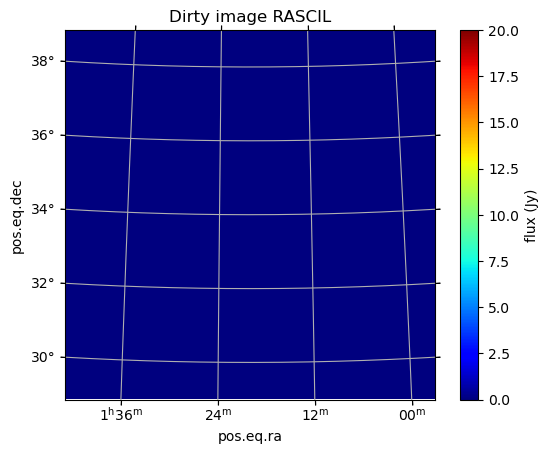

In [11]:
# Imaging with RASCIL
dirty_rascil = dirty_imager.create_dirty_image(visibility)
dirty_rascil.plot(title="Dirty image RASCIL", vmin=0, vmax=20.0)

In [12]:
testarray = np.array(12.34)
type(testarray)

numpy.ndarray